In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    res = llm_with_tools.invoke(state["messages"])
    print(f"Search agent res:{res}")
    return {
        "messages": [res], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return "END"
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router, {
    "tool_node": "tool_node",
    "END": END
})
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17668\1742597841.py:14: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


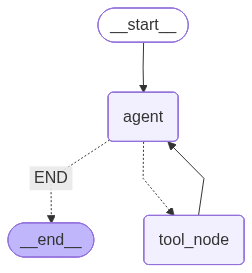

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [4]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})


Search agent res:content='' additional_kwargs={'tool_calls': [{'id': 'whhh5xc4f', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.039886006, 'prompt_time': 0.020682563, 'queue_time': 0.047575037, 'total_time': 0.060568569}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--4e7e5cc9-87e4-4498-b104-7eedb8ee1f1f-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'whhh5xc4f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}
Search agent res:content='The current weather in Chennai is mostly cloudy with a chance of light rain showers and patchy rain possible. The temperature is ar

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='2f1c295d-a232-42c8-ac66-52fe090f0c75'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'whhh5xc4f', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.039886006, 'prompt_time': 0.020682563, 'queue_time': 0.047575037, 'total_time': 0.060568569}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4e7e5cc9-87e4-4498-b104-7eedb8ee1f1f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'whhh5xc4f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306})

## Case 1: Shared Schema (Direct Embedding)

In [5]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result

Search agent res:content='' additional_kwargs={'tool_calls': [{'id': '8f9wzjz3p', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.040353324, 'prompt_time': 0.020709601, 'queue_time': 0.050461018, 'total_time': 0.061062925}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_55d70a61e4', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--acd2d6c8-fbbd-40d8-a125-61dbd1d70029-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': '8f9wzjz3p', 'type': 'tool_call'}] usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}
Search agent res:content='The current weather in Chennai is expected to be patchy with rain showers and cloudy conditions. The temperature is expected to ran

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='18e9b972-889b-452b-9070-2fc8dab47800'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8f9wzjz3p', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.040353324, 'prompt_time': 0.020709601, 'queue_time': 0.050461018, 'total_time': 0.061062925}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_55d70a61e4', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--acd2d6c8-fbbd-40d8-a125-61dbd1d70029-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': '8f9wzjz3p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306})

## Case 2: Different Schema (Invoke with Transformation)

In [6]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    res = HumanMessage(content=state["query"])
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [res]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
print(result)

Search agent res:content='' additional_kwargs={'tool_calls': [{'id': 'x63ed7t00', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.040263622, 'prompt_time': 0.024289952, 'queue_time': 0.050610198, 'total_time': 0.064553574}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--24668bb8-e8e6-4203-9ce3-2e51ea6ca4e9-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'x63ed7t00', 'type': 'tool_call'}] usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}
Search agent res:content='The weather in Chennai is expected to be patchy with rain showers and cloudy conditions throughout the day. The temperature is expe